In [1]:
import pickle
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

import warnings
warnings.filterwarnings('ignore')

In [2]:
import psycopg2
from local_settings import hostname, username, password, port, database

In [3]:
connection = psycopg2.connect(
            host=hostname, user=username, 
            password=password, dbname=database, 
            port=port
        )

In [4]:
sql_query = "SELECT * FROM data_row"

df = pd.read_sql_query(sql_query, connection)

connection.close()
print(df.shape)
df.head(3)

(26912, 19)


,title,address,price,area,bath,room,property_type,description,year,parking,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
2,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",162297,60,2,2,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania


Due to our own pruporse, we want to study those houses which label is 'Casa' or 'Departamento/Apartemento'. Then we drop out labels like 'Casa de playa', 'Casa de campo' and 'Habitación'.

In [5]:
outhome = ['Casa de playa', 'Casa de campo', 'Habitación']
mask = df['property_type'].apply(lambda x: x not in outhome)
df = df[mask]
df.shape

(26560, 19)

In [6]:
df['property_type'] = df['property_type'].str.replace('Apartamento', 'Departamento')
df['property_type'].value_counts()

Departamento    19226
Casa             7334
Name: property_type, dtype: int64

There some values which not correspond actually to Departments or Houses, but entire Hotels, buildings and so on.

In [7]:
id_mansion = df['title'].apply(lambda x: x.lower()).str.extract('((vend\w* edificio|hotel|hostel|mansion|mansión|hostal).*)').dropna().index
df = df.drop(index=id_mansion)
df.shape

(26483, 19)

In [8]:
df = df.drop_duplicates()
df.shape

(22429, 19)

We have already dropped duplicates instances out, but remains some values. So let's be more specific on which column we don't allow duplicates

In [9]:
df = df.drop_duplicates(subset=['address', 'price', 'area', 'bath', 'room', 'parking', 'year', 'property_type'])
df.shape

(21701, 19)

In [10]:
df['description'].fillna('', inplace=True)
df.isna().sum()

title            0
address          0
price            0
area             0
bath             0
room             0
property_type    0
description      0
year             0
parking          0
near_cc          0
near_school      0
near_parks       0
near_avenue      0
security         0
elevator         0
rest_area        0
pool             0
web              0
dtype: int64

In [11]:
df = df[df['bath'] != 0]
df.shape

(21681, 19)

Once again, due to our own pruporse we just consider departments priced lower than 250,000 USD and houses priced lower than 300,000 USD

In [12]:
threshold_dep = 250000
threshold_casa = 300000
mask = ((df['property_type'] == 'Departamento') & (df['price'] < threshold_dep)) | ((df['property_type'] == 'Casa') & (df['price'] < threshold_casa))
df = df.loc[mask]
df['property_type'].value_counts()

Departamento    11531
Casa             2839
Name: property_type, dtype: int64

In [13]:
threshold_dep = 10000
threshold_casa = 15000
mask = ((df['property_type'] == 'Departamento') & (df['price'] > threshold_dep)) | ((df['property_type'] == 'Casa') & (df['price'] > threshold_casa))
df = df.loc[mask]
df['property_type'].value_counts()

Departamento    11491
Casa             2815
Name: property_type, dtype: int64

In [14]:
df['id'] = range(0,df.shape[0])
df.set_index('id', inplace=True)
df.head(2)

,title,address,price,area,bath,room,property_type,description,year,parking,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web
id,,,,,,,,,,,,,,,,,,,
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania


In [15]:
df['web'].value_counts()

Urbania    8929
Mitula     3232
Trovit     2145
Name: web, dtype: int64

We want to know the ranking of property based in his ubication

In [16]:
def clean_text(text):
    cleaned = unidecode(text.lower())
    cleaned = ''.join(e for e in cleaned if e.isalnum() or e.isspace())

    return cleaned

In [17]:
df["clean_address"] = df["address"].apply(clean_text)
df["clean_address"]

id
0          calle coronel odriozola 128 san isidrolima lima
1          calle coronel odriozola 128 san isidrolima lima
2          calle coronel odriozola 128 san isidrolima lima
3          calle coronel odriozola 128 san isidrolima lima
4        jiron batallon callao norte   santa teresasant...
                               ...                        
14301    jiron inca ripac 197 jesus maria peru  jesus m...
14302        cnel gregorio albarracin lanchipa tacna tacna
14303    san juan de lurigancho 15427 peru  san juan de...
14304    parque iii  los gladiolos terreno ate peru  at...
14305    calle arturo duray 411 surquillo peru  surquil...
Name: clean_address, Length: 14306, dtype: object

In [18]:
dept = []

for i in df["clean_address"]:
    if re.search(r'\blima\b', i):
        dept.append('Lima')
    else:
        dept.append('')

df['dept'] = dept
df = df[df['dept'] != '']

In [19]:
districts = ['san juan de miraflores',
            'callao',
            'miraflores',
            'san isidro',
            'surco',
            'barranco',
            'chorrillos',
            'san borja',
            'lince',
            'la molina',
            'cercado de lima',
            'magdalena del mar',
            'carabayllo',
            'comas',
            'pueblo libre',
            'jesus maria',
            'la victoria',
            'los olivos',
            'lurigancho',
            'ate',
            'magdalena',
            'san martin',
            'san miguel',
            'surquillo',
            'san juan de lurigancho',
            'provincia de lima',
            'santiago de surco',
            'cercado',
            'limalima'
            ]

In [20]:
district = []

for ub in df["clean_address"]:
    dis = ""

    for d in districts:
        if re.search(f'.*{d}.*', ub):
            dis = d
            break

    district.append(dis.title())

In [21]:
for i in range(len(district)):
    dis = district[i]
    if dis == 'Limalima' or dis == 'Provincia De Lima' or dis == 'Cercado':
        district[i] = 'Cercado De Lima'
    if dis == 'San Juan De Lurigancho':
        district[i] = 'Lurigancho'
    if dis == 'Santiago De Surco':
        district[i] = 'Surco'
    if dis == 'Magdalena':
        district[i] = 'Magdalena Del Mar'
    if dis == 'San Juan De Miraflores':
        district[i] = 'Callao'

In [22]:
df["district"] = district
#df = df[df["district"] != ""]
df["district"].value_counts()

Surco                1671
                     1404
Miraflores            977
Surquillo             658
San Miguel            587
Jesus Maria           513
Cercado De Lima       473
Lince                 396
San Isidro            395
Chorrillos            382
Magdalena Del Mar     362
Los Olivos            360
Barranco              353
Pueblo Libre          352
Ate                   340
San Martin            313
Lurigancho            295
Carabayllo            257
San Borja             253
Callao                247
La Molina             238
La Victoria           195
Comas                 158
Name: district, dtype: int64

In [23]:
with open("dataset/estratos.pkl", 'rb') as file:
    estratos = pickle.load(file)

In [24]:
df['ranking'] = df['district'].map(estratos)

In [25]:
df.ranking.isnull().sum()

1404

In [26]:
df.ranking.unique()

array([5.  , 3.13, 2.71, 4.27, 4.59, 4.76, 4.66,  nan, 1.9 , 4.95, 4.11,
       1.46, 3.22, 4.49, 3.21, 2.36, 3.27, 4.4 , 1.51, 2.8 ])

Fill nan ranking 

In [27]:
# Aplicar condiciones
condicion = (df['property_type'] == 'Departamento') & (df['ranking'].isnull())

# Filtrar los datos que cumplen con la condición
datos_filtrados = df[condicion]

# Dividir los valores de 'price' en 15 segmentos y asignar números del 1 al 15 a la columna 'rango'
datos_filtrados['rango'] = pd.cut(datos_filtrados['price'], bins=15, labels=range(1, 16))

# Actualizar el DataFrame original con los nuevos valores de 'rango'
df.loc[condicion, 'rango'] = datos_filtrados['rango']

In [28]:
rango_dict = {1: 2.71, 2: 2.36, 3: 2.8, 4: 3.21, 5: 3.27, 6: 4.11, 7: 4.27, 8: 4.4, 9: 4.4, 10: 4.49, 11: 4.49, 12: 4.66, 13: 4.49, 14: 4.66, 15: 4.76}
df['ranking'].fillna(df['rango'].map(rango_dict), inplace=True)

In [29]:
df.ranking.isnull().sum()

584

In [30]:
# Aplicar condiciones
condicion = (df['property_type'] == 'Casa') & (df['ranking'].isnull())

# Filtrar los datos que cumplen con la condición
datos_filtrados = df[condicion]

# Dividir los valores de 'price' en 15 segmentos y asignar números del 1 al 15 a la columna 'rango'
datos_filtrados['rango'] = pd.cut(datos_filtrados['price'], bins=15, labels=range(1, 16))

# Actualizar el DataFrame original con los nuevos valores de 'rango'
df.loc[condicion, 'rango'] = datos_filtrados['rango']

In [31]:
rango_dict = {1:  1.51, 2: 1.9, 3: 2.36, 4: 2.36, 5: 2.71, 6: 2.71, 7: 2.71, 8: 2.8, 9: 2.8, 10: 3.13, 11: 2.8, 12: 3.21, 13: 3.22, 14: 3.27, 15: 3.27}
df['ranking'].fillna(df['rango'].map(rango_dict), inplace=True)

In [32]:
df.ranking.isnull().sum()

0

## Distritos en Lima Provincia

In [33]:
df['district'].unique()

array(['San Isidro', 'Callao', 'Chorrillos', 'Lince', 'Surco',
       'Miraflores', 'La Molina', 'San Miguel', '', 'Carabayllo',
       'San Borja', 'Barranco', 'Magdalena Del Mar', 'Lurigancho',
       'Jesus Maria', 'Los Olivos', 'Surquillo', 'Cercado De Lima',
       'Comas', 'La Victoria', 'Pueblo Libre', 'Ate', 'San Martin'],
      dtype=object)

In [34]:
lima_provincia = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Distritos_de_Lima', header=1)[0]
lima_provincia.head()

,Distritos,Ubigeo,Área (km²),Censo 2017,Estimación 2023[1]​,Fundación,Código postal,Mapa de ubicación
0,Ancón,150102,299.22,62 928,91 170,NaN,2,NaN
1,Ate,150103,77.72,599 196,713 103,NaN,3,NaN
2,Barranco,150104,3.33,34 378,37 525,NaN,4,NaN
3,Breña,150105,3.22,85 309,97 906,NaN,5,NaN
4,Carabayllo,150106,346.88,333 045,426 985,NaN,6,NaN


In [35]:
{kk: vv for kk, vv in zip(lima_provincia['Distritos'],lima_provincia['Ubigeo'])}

{'Ancón': 150102,
 'Ate': 150103,
 'Barranco': 150104,
 'Breña': 150105,
 'Carabayllo': 150106,
 'Chaclacayo': 150107,
 'Chorrillos': 150108,
 'Cieneguilla': 150109,
 'Comas': 150110,
 'El Agustino': 150111,
 'Independencia': 150112,
 'Jesús María': 150113,
 'La Molina': 150114,
 'La Victoria': 150115,
 'Lima': 150101,
 'Lince': 150116,
 'Los Olivos': 150117,
 'Lurigancho': 150118,
 'Lurín': 150119,
 'Magdalena del Mar': 150120,
 'Miraflores': 150122,
 'Pachacamac': 150123,
 'Pucusana': 150124,
 'Pueblo Libre': 150121,
 'Puente Piedra': 150125,
 'Punta Hermosa': 150126,
 'Punta Negra': 150127,
 'Rímac': 150128,
 'San Bartolo': 150129,
 'San Borja': 150130,
 'San Isidro': 150131,
 'San Juan de Lurigancho': 150132,
 'San Juan de Miraflores': 150133,
 'San Luis': 150134,
 'San Martín de Porres': 150135,
 'San Miguel': 150136,
 'Santa Anita': 150137,
 'Santa María del Mar': 150138,
 'Santa Rosa': 150139,
 'Santiago de Surco': 150140,
 'Surquillo': 150141,
 'Villa El Salvador': 150142,
 'Vi

# EDA

## Variable Distribution

In [36]:
df.columns

Index(['title', 'address', 'price', 'area', 'bath', 'room', 'property_type',
       'description', 'year', 'parking', 'near_cc', 'near_school',
       'near_parks', 'near_avenue', 'security', 'elevator', 'rest_area',
       'pool', 'web', 'clean_address', 'dept', 'district', 'ranking', 'rango'],
      dtype='object')

Let's create a new dataframe which contains only the numerical variables, i.e., 'price', 'area', 'bath', 'room', 'parking' and 'year'.

In [37]:
df_num = df[['price', 'area', 'bath', 'room', 'parking', 'year', 'property_type', 'near_cc', 'near_school',
       'near_parks', 'near_avenue', 'security', 'elevator', 'rest_area','pool', 'ranking']]
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11179 entries, 0 to 14305
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          11179 non-null  int64  
 1   area           11179 non-null  int64  
 2   bath           11179 non-null  int64  
 3   room           11179 non-null  int64  
 4   parking        11179 non-null  int64  
 5   year           11179 non-null  int64  
 6   property_type  11179 non-null  object 
 7   near_cc        11179 non-null  int64  
 8   near_school    11179 non-null  int64  
 9   near_parks     11179 non-null  int64  
 10  near_avenue    11179 non-null  int64  
 11  security       11179 non-null  int64  
 12  elevator       11179 non-null  int64  
 13  rest_area      11179 non-null  int64  
 14  pool           11179 non-null  int64  
 15  ranking        11179 non-null  float64
dtypes: float64(1), int64(14), object(1)
memory usage: 1.4+ MB


As the first step, we plot the distribution of each variable in order to know where its outliers.

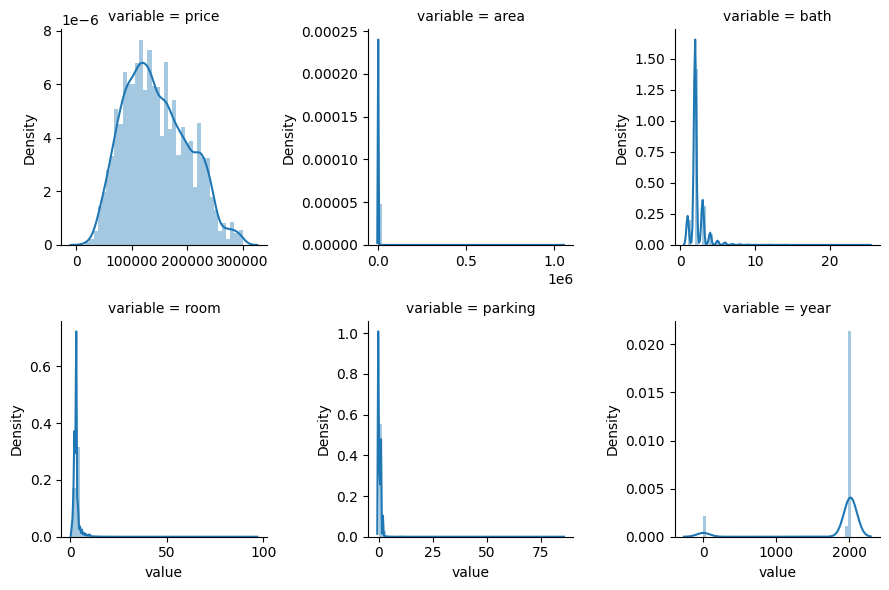

In [38]:
f = pd.melt(df_num.iloc[:,:6], value_vars=df_num.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

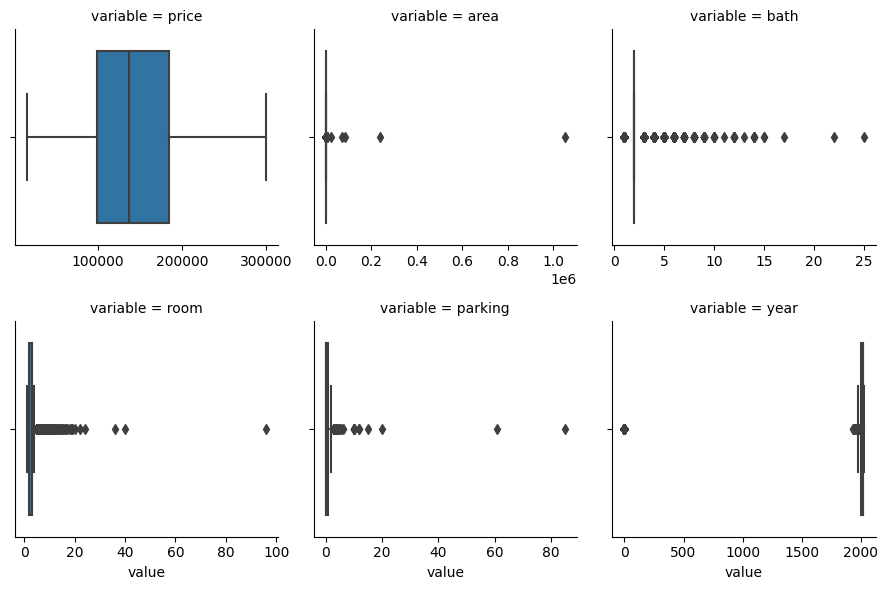

In [39]:
f = pd.melt(df_num.iloc[:,:6], value_vars=df_num.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

As we can appreciate, all variables have outliers, but 'price'. 

In [40]:
def outliers(column, df_outlier):
    Q1 = df_outlier[column].dropna().quantile(0.25)
    Q3 = df_outlier[column].dropna().quantile(0.75)
    IQR = Q3 - Q1

    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    return lower_whisker, upper_whisker

We point out for clients which buy its first house, then a housing which has a big area would not be a good option for a first house.

In [41]:
threshold = 500
mask = (df_num['area'] < threshold)
df_num = df_num[mask]
df_num.shape

(11099, 16)

## Outliers Casa & Departamento

Because Department and Houses has different dimensions and settings, we split the analysis among each property_type label.

In [42]:
mask = df_num['property_type'] == 'Departamento'
df_departamento = df_num.loc[mask]
mask = df_num['property_type'] == 'Casa'
df_casa = df_num.loc[mask]
print(df_departamento.shape, df_casa.shape)

(9470, 16) (1629, 16)


### Departamento

#### Outliers Area

We choose 'area' for our standard parameter, in order to contrast the other variables and take a decision aboout what instance gets drop out.

In [43]:
lower_darea, upper_darea = outliers('area', df_departamento)
lower_darea, upper_darea

(5.0, 165.0)

Hence using the outlier values, let's see which instance could be useful. For that a 2D histogram would be a good idea to see how data of 'area' and number of 'room' is distributed.

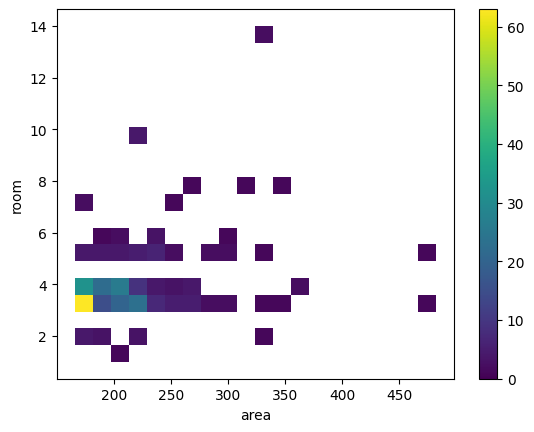

In [44]:
mask = df_departamento['area'] > upper_darea
plt.figure()
sns.histplot(data=df_departamento.loc[mask], x='area', y='room', bins=20, cmap='viridis', cbar=True)
plt.show()

For this data, let's see what is the most common range for number of rooms

In [45]:
mask = (df_departamento['area'] > upper_darea)
lower_room, upper_room = outliers('room', df_departamento[mask])
lower_room, upper_room

(1.5, 5.5)

According to this result, housing having more that 5 rooms and less than 3 room are dropped out.

In [46]:
mask = (df_departamento['area'] > upper_darea) & ((df_departamento['room'] <= 2)|(df_departamento['room'] >= 6))
print(df_departamento.loc[mask].shape)
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(31, 16)


(9439, 16)

Let's do the same for 'bath' variable

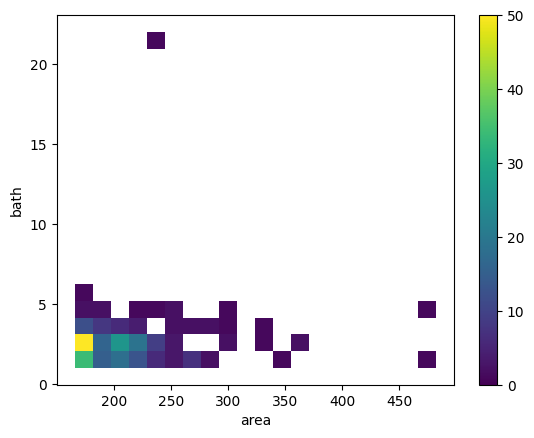

In [47]:
mask = df_departamento['area'] > upper_darea
plt.figure()
sns.histplot(data=df_departamento.loc[mask], x='area', y='bath', bins=20, cmap='viridis', cbar=True)
plt.show()

As well as before, instaces with more then 5 and less than 2 bath are dropped out.

In [48]:
mask = (df_departamento['area'] > upper_darea) & ((df_departamento['bath'] <= 1)|(df_departamento['bath'] >= 6))
print(df_departamento[mask].shape)
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(5, 16)


(9434, 16)

#### Outliers Room & Bath

Now let's analyses the variables 'room' and 'bath' for itself.
Let's compute its outliers and let them go away.

In [49]:
lower_droom, upper_droom = outliers('room', df_departamento)
lower_droom, upper_droom

(0.5, 4.5)

In [50]:
mask = df_departamento['room'] < 5
print(df_departamento[~mask].shape)
df_departamento = df_departamento[mask]
df_departamento.shape

(82, 16)


(9352, 16)

In [51]:
lower_dbath, upper_dbath = outliers('bath', df_departamento)
lower_dbath, upper_dbath

(2.0, 2.0)

In [52]:
mask = df_departamento['bath'] < 5
print(df_departamento[~mask].shape)
df_departamento = df_departamento.loc[mask]
df_departamento.shape

(22, 16)


(9330, 16)

#### Bath < Room

Now let's analyse both parameters together.

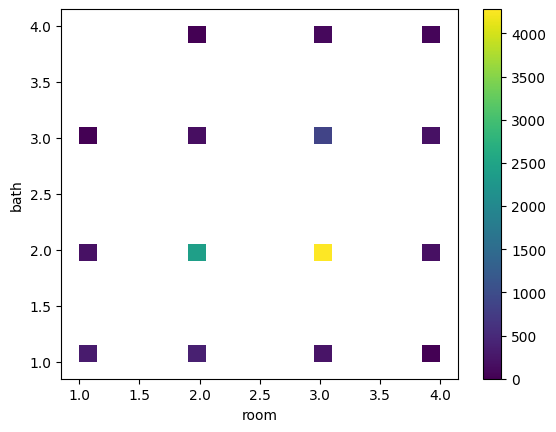

In [53]:
plt.figure()
sns.histplot(data=df_departamento.loc[mask], x='room', y='bath', bins=20, cmap='viridis', cbar=True)
plt.show()

We can appreciate than there are several cases where exist more bath than rooms. Let's drop out that instances.

In [54]:
mask = df_departamento['bath'] > df_departamento['room']
print(df_departamento[mask].shape)
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(436, 16)


(8894, 16)

#### Outlier Parking

In [55]:
lower_dparking, upper_dparking = outliers('parking', df_departamento)
lower_dparking, upper_dparking

(-1.5, 2.5)

In [56]:
mask = df_departamento['parking'] <= 2
df_departamento = df_departamento.loc[mask]
df_departamento.shape

(8881, 16)

In [57]:
df_departamento['parking'] = df_departamento['parking'].replace(2, 1)
df_departamento.shape

(8881, 16)

In [58]:
df_departamento['parking'].value_counts()

0    5598
1    3283
Name: parking, dtype: int64

#### Outlier Year

There are some data in 'year' which is 0, let's replaced by random values, between 2000 and 2020

In [59]:
# mask = (df_departamento['year'] != 0) & (df_departamento['year'] != 2023) 
# new_year = int(df_departamento.loc[mask, 'year'].median())
mask = df_departamento['year'] == 0
size = df_departamento.loc[mask].shape[0]
df_departamento.loc[mask, 'year'] = np.random.normal(2010, 5, size).astype(int)
df_departamento.shape

(8881, 16)

In [60]:
mask = df_departamento['year'] > 2023
df_departamento.loc[mask, 'year'] = [2023] * df_departamento.loc[mask].shape[0]
df_departamento['year'] = df_departamento['year'].astype(int)
df_departamento['year'].value_counts()

2023    3578
2013     419
2022     385
2018     294
2016     284
        ... 
1964       2
1949       1
1932       1
1946       1
1941       1
Name: year, Length: 73, dtype: int64

Let's see how the distributions have changed

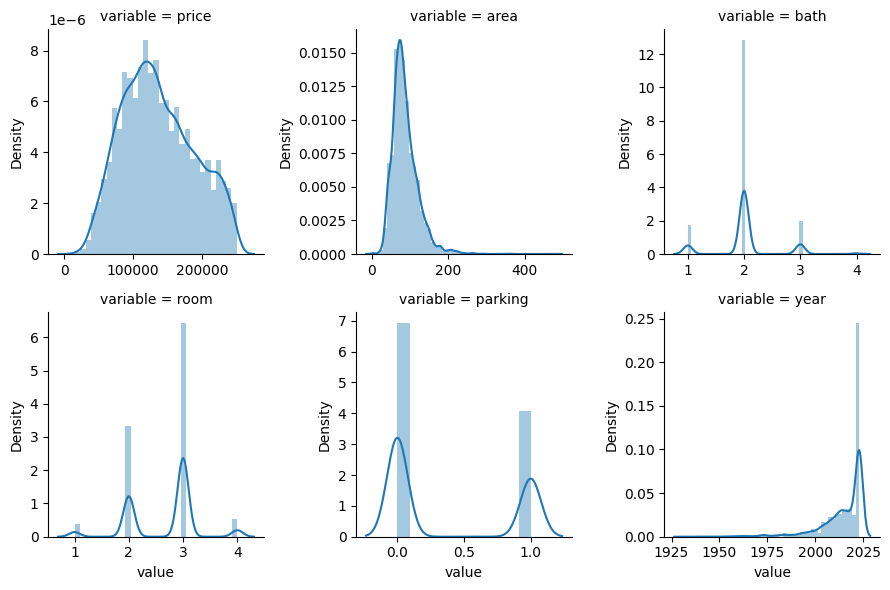

In [61]:
f = pd.melt(df_departamento.iloc[:,:6], value_vars=df_departamento.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

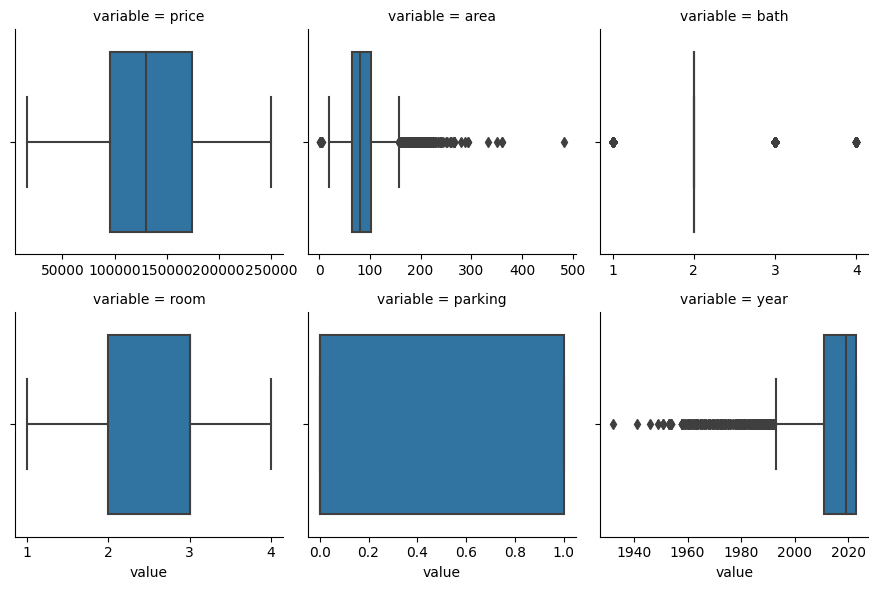

In [62]:
f = pd.melt(df_departamento.iloc[:,:6], value_vars=df_departamento.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

### Casa

#### Outliers Area

In [63]:
lower_carea, upper_carea = outliers('area', df_casa)
lower_carea, upper_carea

(-37.0, 371.0)

In [64]:
mask = df_casa['area'] > upper_carea
df_casa = df_casa.loc[~mask]


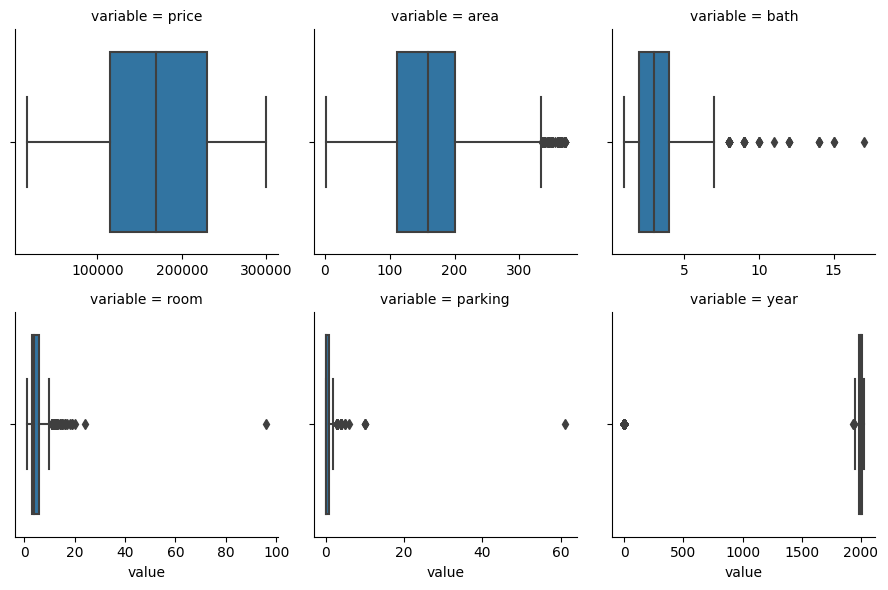

In [65]:
f = pd.melt(df_casa.iloc[:,:6], value_vars=df_casa.columns[:6])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

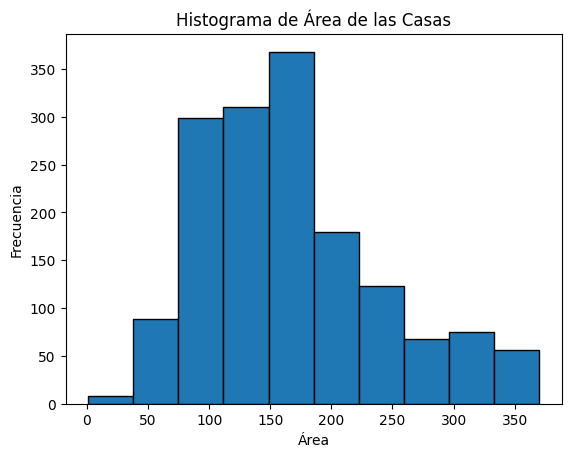

In [66]:
plt.hist(df_casa["area"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Área")
plt.ylabel("Frecuencia")
plt.title("Histograma de Área de las Casas")

# Mostrar el gráfico
plt.show()


In [67]:
mask = df_casa['area'] < 30
df_casa = df_casa.loc[~mask]

#### Outliers Room & Bath

In [68]:
lower_croom, upper_croom = outliers('room', df_casa)
lower_croom, upper_croom

(-1.5, 10.5)

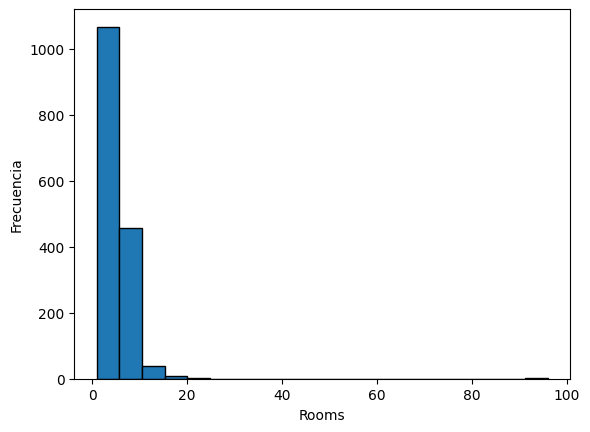

In [69]:
plt.hist(df_casa["room"], edgecolor='k', bins= 20)

# Configurar etiquetas y título
plt.xlabel("Rooms")
plt.ylabel("Frecuencia")
plt.show()


In [70]:
mask = df_casa['room'] > 10
df_casa = df_casa[~mask]
df_casa.shape

(1522, 16)

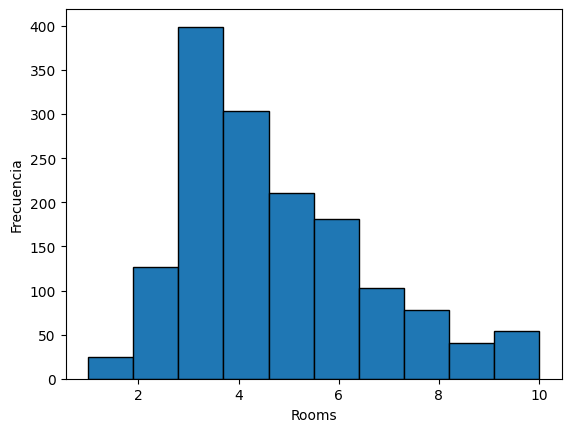

In [71]:
plt.hist(df_casa["room"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Rooms")
plt.ylabel("Frecuencia")
plt.show()


In [72]:
#id_hotel = df[df["room"] >10]['description'].apply(lambda x: x.lower()).str.extract('(hotel)').dropna().index
#df.loc[id_hotel]

In [73]:
lower_cbath, upper_cbath = outliers('bath', df_casa)
lower_cbath, upper_cbath

(-1.0, 7.0)

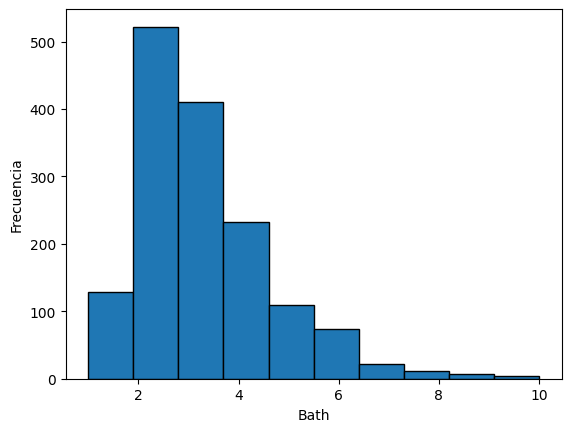

In [74]:
plt.hist(df_casa["bath"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Bath")
plt.ylabel("Frecuencia")
plt.show()


In [75]:
mask = df_casa['bath'] > 7
df_casa = df_casa[~mask]
df_casa.shape

(1500, 16)

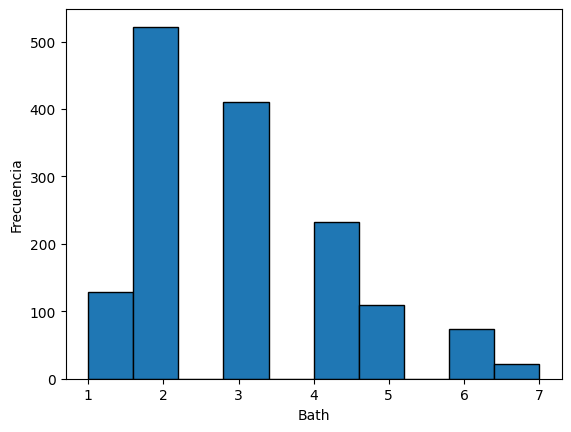

In [76]:
plt.hist(df_casa["bath"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Bath")
plt.ylabel("Frecuencia")
plt.show()


#### Bath < Room

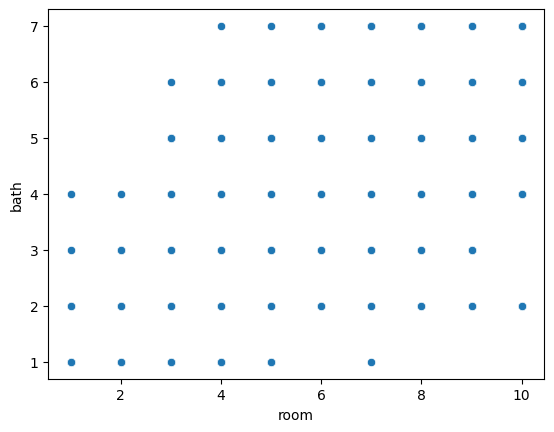

In [77]:
plt.figure()
sns.scatterplot(data=df_casa, x='room', y='bath')
plt.show()

In [78]:
mask = df_casa['bath'] > df_casa['room']
df_casa = df_casa.loc[~mask]
df_casa.shape

(1436, 16)

#### Outlier Parking

In [79]:
lower_cparking, upper_cparking = outliers('parking', df_casa)
lower_cparking, upper_cparking

(-1.5, 2.5)

In [80]:
mask = df_casa['parking'] <= 2
df_casa = df_casa.loc[mask]


In [81]:
df_casa['parking'] = df_casa['parking'].replace(2, 1)
df_casa.shape

(1403, 16)

In [82]:
df_casa['parking'].value_counts()

0    807
1    596
Name: parking, dtype: int64

#### Outlier Year

In [83]:
df_casa.loc[df_casa['year'] == 0]

,price,area,bath,room,parking,year,property_type,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,ranking
id,,,,,,,,,,,,,,,,
413,178378,338,2,4,0,0,Casa,1,0,1,1,0,0,0,0,2.80
1214,280000,360,5,6,1,0,Casa,0,0,1,0,0,0,1,0,3.27
2344,170000,350,5,9,0,0,Casa,0,0,0,0,0,0,0,0,3.21
2654,135000,239,3,4,1,0,Casa,1,1,1,1,0,0,1,0,2.71
2857,106900,120,4,4,1,0,Casa,0,0,1,1,0,0,1,0,1.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14182,180000,311,4,7,1,0,Casa,1,1,1,1,0,0,1,0,3.13
14188,290000,320,3,3,0,0,Casa,1,1,1,1,0,0,0,0,3.21
14212,270000,200,3,4,1,0,Casa,0,1,1,1,0,0,1,0,3.27


In [84]:
df_casa["year"].value_counts()

0       180
2013     92
2023     89
2008     75
2003     59
       ... 
1953      1
1933      1
1947      1
1964      1
1940      1
Name: year, Length: 72, dtype: int64

In [85]:
mask = (df_casa['year'] != 0) & (df_casa['year'] != 2023) 
new_year = int(df_casa.loc[mask, 'year'].median())
df_casa['year'] = df_casa['year'].replace(0, new_year)
df_casa.shape

(1403, 16)

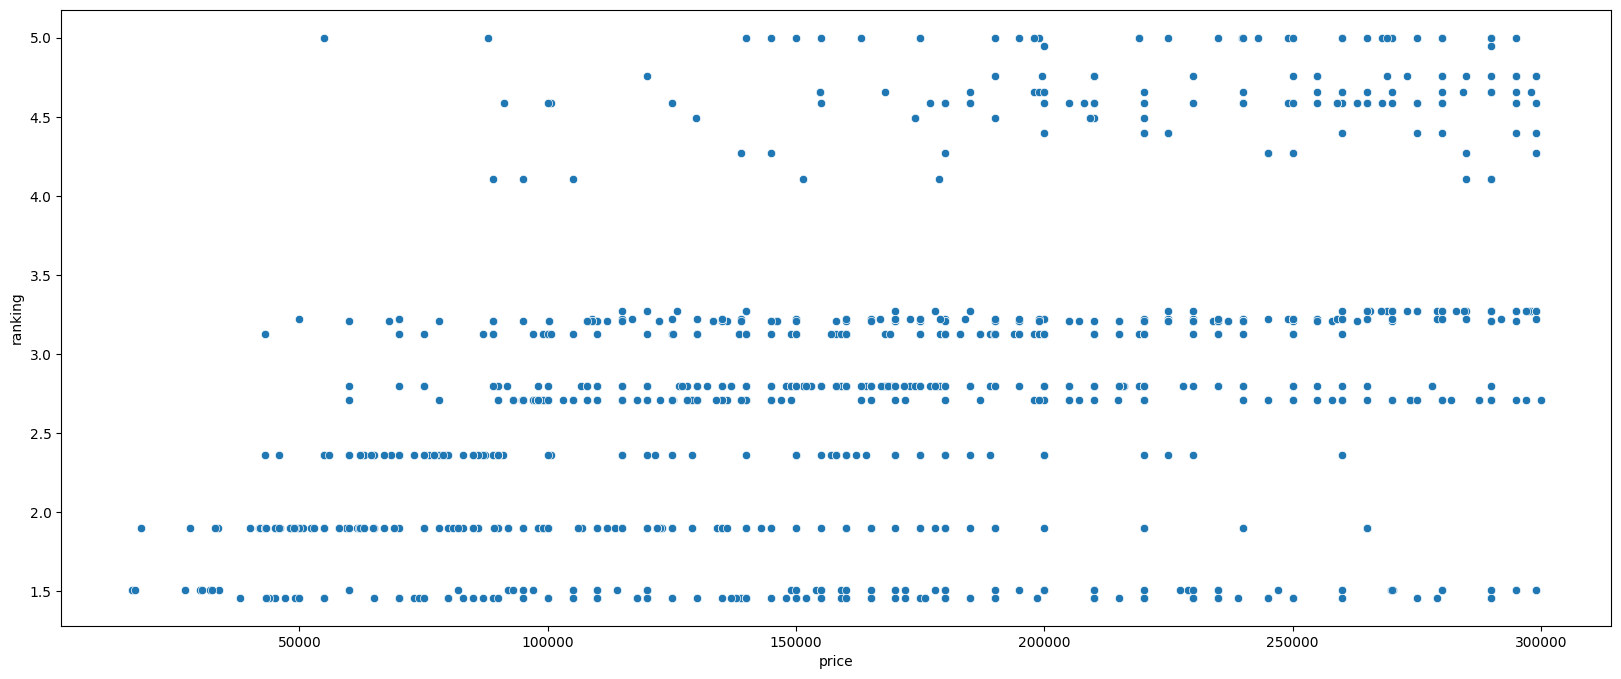

In [86]:
plt.figure(figsize= (20,8))
sns.scatterplot(data=df_casa, x='price', y='ranking')
plt.show()

## Merge of both data set

In [87]:
df_casa["property_type"] = 2

In [88]:
df_departamento["property_type"] = 1

In [89]:
df_final = pd.concat([df_departamento, df_casa], ignore_index=True)

In [90]:
df_final.to_csv("data_casa_depto.csv")